In [ ]:
# in case some packages are missing. Install them using following cmd
# !pip install linearmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 2.2 MB/s eta 0:00:00


In [ ]:
# data load on google colab
import io
from google.colab import files

# Load packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
import seaborn as sns

## models
from linearmodels import PooledOLS
from linearmodels import PanelOLS
from linearmodels import RandomEffects

## tests
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white, het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from scipy import stats
def hausman(fe, re):
    b = fe.params
    B = re.params
    v_b = fe.cov
    v_B = re.cov

    df = b[np.abs(b) < 1e8].size
    chi2 = np.dot((b - B).T, la.inv(v_b - v_B).dot(b - B))

    pval = stats.chi2.sf(chi2, df)
    return chi2, df, pval

## show results
from collections import OrderedDict
from linearmodels.panel import compare



ModuleNotFoundError: ignored

In [ ]:
# 1. Load data
uploaded = files.upload()
dataset = pd.read_csv(io.BytesIO(uploaded['Guns.csv']),
                      usecols=['state', 'year', 'income', 'violent'],
                      index_col=['state', 'year'])
dataset_full = pd.read_csv(io.BytesIO(uploaded['Guns.csv']))
years = dataset.index.get_level_values('year').to_list()
dataset['year'] = pd.Categorical(years)



Saving Guns.csv to Guns.csv


                          PooledOLS Estimation Summary                          
Dep. Variable:                violent   R-squared:                        0.1665
Estimator:                  PooledOLS   R-squared (Between):              0.1940
No. Observations:                1173   R-squared (Within):              -0.0720
Date:                Tue, May 09 2023   R-squared (Overall):              0.1665
Time:                        18:15:13   Log-likelihood                   -8374.6
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      233.84
Entities:                          51   P-value                           0.0000
Avg Obs:                       23.000   Distribution:                  F(1,1171)
Min Obs:                       23.000                                           
Max Obs:                       23.000   F-statistic (robust):             5.5967
                            

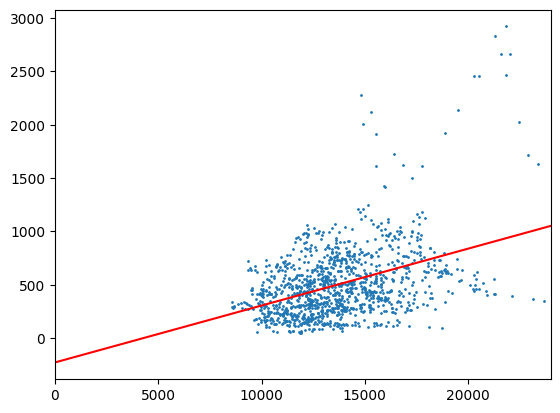

In [ ]:
# 2. PooledOLS example
exog = sm.tools.tools.add_constant(dataset['income'])
endog = dataset['violent']
mod = PooledOLS(endog, exog)
pooledOLS_res = mod.fit(cov_type='clustered', cluster_entity=True)
pooledOLS_res_robust = mod.fit(cov_type="robust")
print(pooledOLS_res)
# Store values for checking homoskedasticity graphically
fittedvals_pooled_OLS = pooledOLS_res.predict().fitted_values
residuals_pooled_OLS = pooledOLS_res.resids

# plot data + POLS fit
plt.scatter(dataset['income'], dataset['violent'], s = 1)
plt.xlim(0, 24000)
axes = plt.gca()
x_vals = np.array(axes.get_xlim())
y_vals = pooledOLS_res.params['const'] + pooledOLS_res.params['income'] * x_vals
plt.plot(x_vals, y_vals, c = 'red')
plt.show()

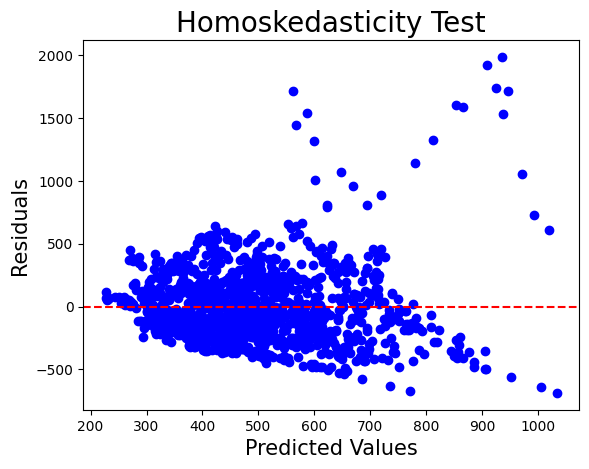

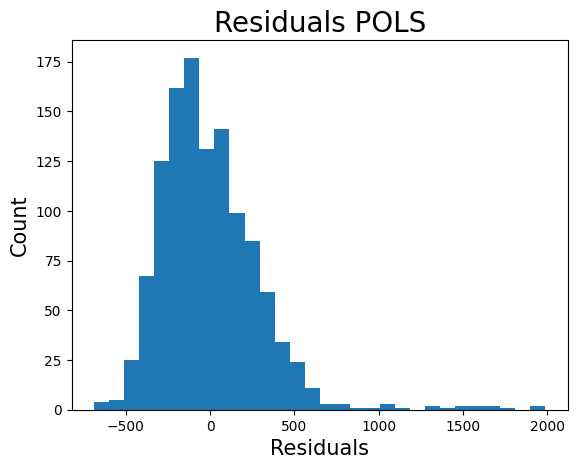

{'LM-Stat': 200.15502156044542, 'LM p-val': 3.442621728589391e-44, 'F-Stat': 120.35903993735391, 'F p-val': 2.9254535557178634e-48}
{'LM-Stat': 110.96166044221732, 'LM p-val': 6.032616972194746e-26, 'F-Stat': 122.34596392437214, 'F p-val': 4.048137598792713e-27}
0.08937264851640209


In [ ]:
# 3. Assumption testing
# 3A.1 Residuals-Plot
fig, ax = plt.subplots()
ax.scatter(fittedvals_pooled_OLS, residuals_pooled_OLS, color='blue')
ax.axhline(0, color='r', ls='--')
ax.set_xlabel('Predicted Values', fontsize=15)
ax.set_ylabel('Residuals', fontsize=15)
ax.set_title('Homoskedasticity Test', fontsize=20)
plt.show()

plt.hist(residuals_pooled_OLS, bins = 30)
plt.xlabel("Residuals", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.title('Residuals POLS', fontsize=20)
plt.show()

# 3A.2 White-Test
# if p < 0.05, then heteroskedasticity is indicated (Homoskedascity assumption is violated)
pooled_OLS_dataset = pd.concat([dataset, residuals_pooled_OLS], axis=1)
pooled_OLS_dataset = pooled_OLS_dataset.drop(['year'], axis = 1).fillna(0)
exog = sm.tools.tools.add_constant(dataset['income']).fillna(0)
white_test_results = het_white(pooled_OLS_dataset['residual'], exog)
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, white_test_results)))
# 3A.3 Breusch-Pagan-Test
breusch_pagan_test_results = het_breuschpagan(pooled_OLS_dataset['residual'], exog)
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, breusch_pagan_test_results)))

# 3B Non-Autocorrelation
# Durbin-Watson-Test
# The Durbin-Watson-Test will have one output between 0 – 4.
# The mean (= 2) would indicate that there is no autocorrelation identified,
# 0 – 2 means positive autocorrelation (the nearer to zero the higher the correlation),
# and 2 – 4 means negative autocorrelation (the nearer to four the higher the correlation).
durbin_watson_test_results = durbin_watson(pooled_OLS_dataset['residual'])
print(durbin_watson_test_results)



In [ ]:
# 4. Run FE/RE models
# FE und RE model
exog = sm.tools.tools.add_constant(dataset['income'])
endog = dataset['violent']
# random effects model
model_re = RandomEffects(endog, exog)
re_res = model_re.fit()
# fixed effects model
model_fe = PanelOLS(endog, exog, entity_effects = True)
fe_res = model_fe.fit()
# fixed effects model with robust estimator
fe_res_robust = model_fe.fit(cov_type="robust")
fe_res_robust.params["const"] + fe_res_robust.params["income"] * 1000

#print results
print(re_res)
print(fe_res)
print(fe_res_robust)

res = OrderedDict()
res["RE"] = re_res
res["FE"] = fe_res
res["FE_rob"] = fe_res_robust
print(compare(res))



                        RandomEffects Estimation Summary                        
Dep. Variable:                violent   R-squared:                        0.1128
Estimator:              RandomEffects   R-squared (Between):              0.1159
No. Observations:                1173   R-squared (Within):               0.1127
Date:                Fri, May 05 2023   R-squared (Overall):              0.1156
Time:                        15:54:06   Log-likelihood                   -7109.8
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      148.90
Entities:                          51   P-value                           0.0000
Avg Obs:                       23.000   Distribution:                  F(1,1171)
Min Obs:                       23.000                                           
Max Obs:                       23.000   F-statistic (robust):             148.90
                            

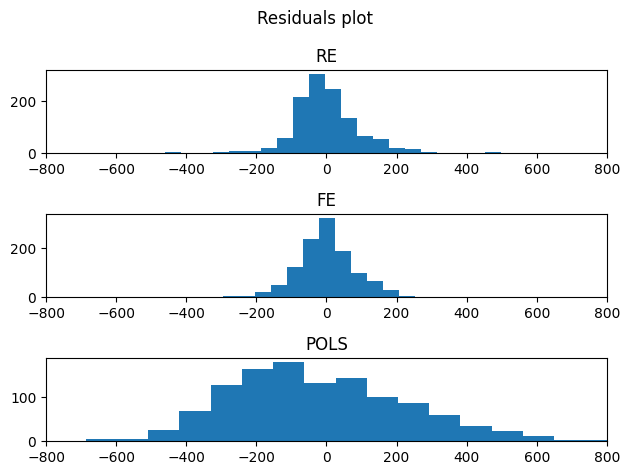

chi - Squared: 9.4263713434208
degrees of freedom: 2
p - Value: 0.00897613696126368
0.3901817492820307


In [ ]:
# 5. Test again
# residuals
residuals_re = re_res.resids
residuals_fe = fe_res.resids

fig, axs = plt.subplots(3)
fig.suptitle('Residuals plot')
axs[0].hist(residuals_re, bins = 30, label = 'RE')
axs[0].set_title("RE")
axs[0].set_xlim(-800, 800)
axs[1].hist(residuals_fe, bins = 30, label = 'FE')
axs[1].set_title("FE")
axs[1].set_xlim(-800, 800)
axs[2].hist(residuals_pooled_OLS, bins = 30, label = 'POLS')
axs[2].set_title("POLS")
axs[2].set_xlim(-800, 800)
fig.tight_layout()
plt.show()

# Hausman test
hausman_results = hausman(fe_res, re_res)
print('chi - Squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p - Value: ' + str(hausman_results[2]))

# Autocorrelation test for FE
durbin_watson_test_results_fe = durbin_watson(residuals_fe)
print(durbin_watson_test_results_fe)

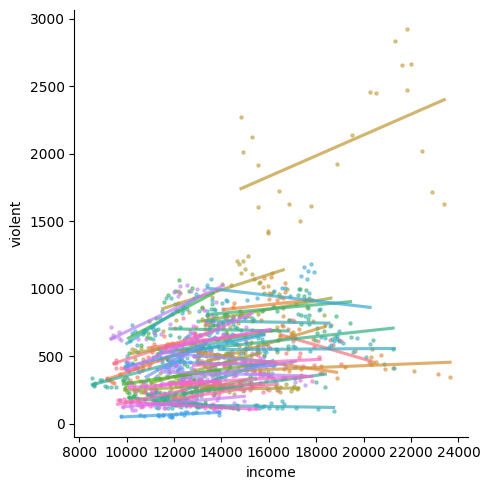

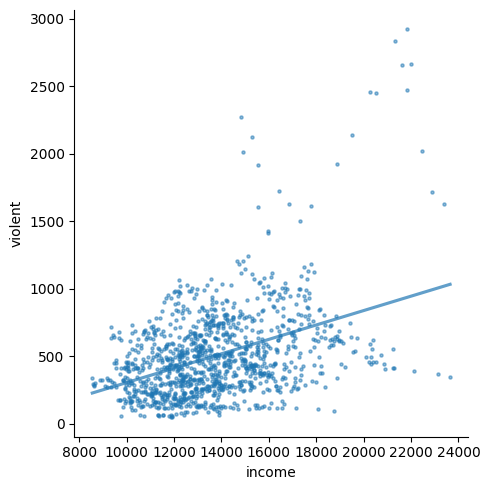

In [ ]:
# Plot - panel structure + POLS
sns.lmplot(x='income',
           y='violent',
           data=dataset_full,
           hue='state',
           fit_reg=True,
           legend = False,
           ci = 0,
           scatter_kws=dict(alpha=0.5, s=5),
           line_kws=dict(alpha=0.7))
sns.lmplot(x='income',
           y='violent',
           data=dataset_full,
           fit_reg=True,
           ci=0,
           scatter_kws=dict(alpha=0.5, s=5),
           line_kws=dict(alpha=0.7))
plt.show()

